# **Preparing data**

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aminedjaboub","key":"54737c86528f659296267e7ddbe0c29f"}'}

In [3]:
import os
import shutil
# Create the kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)
# Move kaggle.json to the correct location
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
# Set the correct permissions
os.chmod('/root/.kaggle/kaggle.json', 600)


In [4]:
!pip install kaggle

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lichess/chess-evaluations")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/lichess/chess-evaluations/versions/5


In [6]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/lichess/chess-evaluations/versions/5"

# List all files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(os.path.join(root, file))


/root/.cache/kagglehub/datasets/lichess/chess-evaluations/versions/5/evals.csv


# **Preparing Dependencies**

In [7]:
!pip install dask memory_profiler pandas pyarrow fastparquet


In [8]:
import pandas as pd
import dask.dataframe as dd
import time
from memory_profiler import memory_usage

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Profiling**

**Chunk size:**

In [9]:
def process_in_chunks(file_path, chunk_size):
    start_time = time.time()
    mem_usage = memory_usage((pd.read_csv, (file_path,), {'chunksize': chunk_size}))
    total_time = time.time() - start_time
    avg_memory = max(mem_usage)

    return total_time, avg_memory

file_path = f"{dataset_path}/evals.csv"
time_taken_chunk, memory_used_chunk = process_in_chunks(file_path,100000)
print(f"Pandas Chunking - Time: {time_taken_chunk:.2f} sec, Memory: {memory_used_chunk:.2f} MB")

Pandas Chunking - Time: 0.32 sec, Memory: 263.72 MB


**DASK:**

In [10]:
def process_with_dask(file_path):
    start_time = time.time()
    mem_usage = memory_usage((dd.read_csv, (file_path,)))
    total_time = time.time() - start_time
    avg_memory = max(mem_usage)

    return total_time, avg_memory

time_taken_dask, memory_used_dask = process_with_dask(file_path)
print(f"Dask - Time: {time_taken_dask:.2f} sec, Memory: {memory_used_dask:.2f} MB")


Dask - Time: 0.49 sec, Memory: 267.92 MB


**Data Compression:**

In [11]:
!pip install pyarrow fastparquet

In [12]:
csv_path = "/root/.cache/kagglehub/datasets/lichess/chess-evaluations/versions/5/evals.csv"
parquet_path = "/content/chess_data.parquet"

chunk_size = 500_000  # Adjust based on memory availability

# Process chunks and save as Parquet
for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunk_size)):
    chunk.to_parquet(parquet_path, compression="snappy", engine="fastparquet", index=False, append=(i > 0))
    print(f"Processed chunk {i + 1}")

print("Conversion completed!")


Processed chunk 1
Processed chunk 2


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [13]:
df = pd.read_parquet(parquet_path)
print(df.head())

                                            fen  \
0  7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -   
1  7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -   
2  7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -   
3  7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -   
4  7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -   

                                                line  depth   knodes     cp  \
0  f7g7 e6e2 h8d8 e2d2 b7b5 c4b3 g7f6 d1e1 a6a5 a2a3     46  4189972   69.0   
1  h8d8 d1e1 a6a5 a2a3 c6d7 e6e7 f7f6 e1f2 b7b5 c4b3     46  4189972  163.0   
2  h8a8 d1e1 a6a5 e6h6 f7g7 h6h4 a8d8 c4d3 c6g2 d3f5     46  4189972  229.0   
3  h8f8 d1e1 b7b5 c4b3 a6a5 e6h6 f7g7 h6h4 f8e8 e1f2     46  4189972  231.0   
4  h8b8 d1e1 a6a5 e6h6 f7g7 h6h4 b8d8 c4d3 c6g2 d3f5     46  4189972  237.0   

   mate  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  


In [14]:
def process_parquet(file_path):
    start_time = time.time()
    mem_usage = memory_usage((pd.read_parquet, (file_path,)))
    total_time = time.time() - start_time
    avg_memory = max(mem_usage)

    return total_time, avg_memory

time_taken_parquet, memory_used_parquet = process_parquet(parquet_path)
print(f"Parquet Compression - Time: {time_taken_parquet:.2f} sec, Memory: {memory_used_parquet:.2f} MB")

Parquet Compression - Time: 1.42 sec, Memory: 1073.30 MB


# **Result Comparison**

In [15]:
results = pd.DataFrame({
    "Method": ["Pandas Chunking", "Dask", "Parquet Compression"],
    "Time (sec)": [time_taken_chunk, time_taken_dask, time_taken_parquet],
    "Memory (MB)": [memory_used_chunk, memory_used_dask, memory_used_parquet]
})

print(results)

                Method  Time (sec)  Memory (MB)
0      Pandas Chunking    0.323358   263.718750
1                 Dask    0.487384   267.917969
2  Parquet Compression    1.415838  1073.296875


**Visual Results**

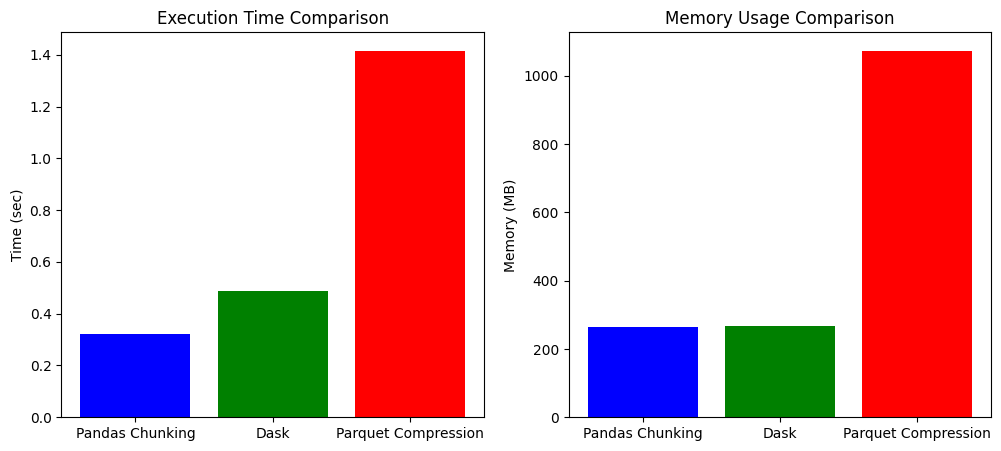

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
ax[0].bar(results["Method"], results["Time (sec)"], color=["blue", "green", "red"])
ax[0].set_title("Execution Time Comparison")
ax[0].set_ylabel("Time (sec)")

# Memory comparison
ax[1].bar(results["Method"], results["Memory (MB)"], color=["blue", "green", "red"])
ax[1].set_title("Memory Usage Comparison")
ax[1].set_ylabel("Memory (MB)")

plt.show()